In [1]:
# Masukkan Data Model
import pandas as pd

df = pd.read_csv("data/train_preprocess.tsv.txt", sep="\t" , names=['Text','Sentimen'])
df.head()

,Text,Sentimen
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [2]:
# Cek Missing Value
df.isnull().sum()

Text        0
Sentimen    0
dtype: int64

In [3]:
# Cek Duplikat
df.duplicated().sum()

67

In [4]:
# Hapus Duplikat
df.drop_duplicates(inplace=True)

In [5]:
# Cek kembali
df.duplicated().sum()

0

In [6]:
import re
import pandas as pd
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Initialize Sastrawi stemmer and stopword remover
factory = StemmerFactory()
stemmer = factory.create_stemmer()

stop_factory = StopWordRemoverFactory()
stop_words = stop_factory.get_stop_words()

# Preprocessing function using Sastrawi
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove non-alphanumeric characters
    text = re.sub(r'[^\w\s]', '', text)
    
    # remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Apply stemming using Sastrawi
    text = stemmer.stem(text)
    
    return text

# Apply the preprocessing function
X = df['Text'].apply(preprocess_text)
Y = df['Sentimen']

# Display the DataFrame with cleaned text
print(X)


0        warung milik usaha pabrik tahu puluh tahun ken...
1        mohon ulama lurus k212 mmbri hujjah partai apa...
2        lokasi strategis jalan sumatera bandung tempat...
3        betapa bahagia nya diri unboxing paket barang ...
4        duh jadi mahasiswa jangan sombong dong kasih k...
                               ...                        
10993      f demokrat dorong upaya mandiri energi nasional
10994                                                bosan
10996    enak rasa masakan nya kepiting senang pilih ke...
10998      pagi pagi tol pasteur macet parah bikin jengkel
10999    meski sering belanja yogya riau junction baru ...
Name: Text, Length: 10933, dtype: object


In [7]:
# Encode labels
from sklearn.calibration import LabelEncoder


le = LabelEncoder()
y = le.fit_transform(Y)

In [8]:
# Split data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:

from sklearn.feature_extraction.text import CountVectorizer

# Inisialisasi CountVectorizer untuk Bag of Words
bow_vectorizer = CountVectorizer(max_features=5000)

# Fit dan transformasi data pelatihan
X_train_bow = bow_vectorizer.fit_transform(X_train).toarray()

# Transformasi data pengujian (menggunakan vektorizer yang sama)
X_test_bow = bow_vectorizer.transform(X_test).toarray()



In [10]:
import pickle

pickle.dump(bow_vectorizer, open ('feature_nn.pickle','wb'))

In [11]:
# Membuat dan Melatih Model dengan MLPClassifier
from sklearn.neural_network import MLPClassifier

model = MLPClassifier()
model.fit(X_train_bow,y_train)

print('Training Done')

Training Done


In [12]:
pickle.dump(model, open('model_nn.pickle','wb'))

In [14]:
# Prediksi pada data test
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_bow)

print('Test Done')
print(classification_report(y_test,y_pred))


Test Done
              precision    recall  f1-score   support

           0       0.78      0.73      0.75       690
           1       0.71      0.73      0.72       220
           2       0.87      0.90      0.89      1277

    accuracy                           0.83      2187
   macro avg       0.79      0.79      0.79      2187
weighted avg       0.83      0.83      0.83      2187



Training Done
Model Accuracy: 0.83


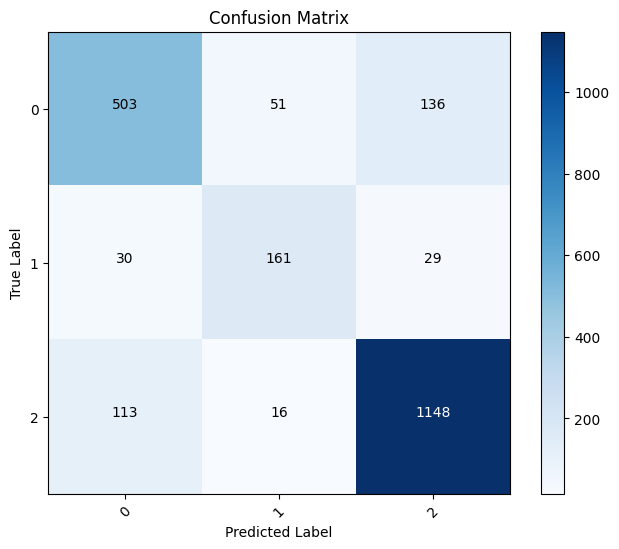


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.73      0.75       690
           1       0.71      0.73      0.72       220
           2       0.87      0.90      0.89      1277

    accuracy                           0.83      2187
   macro avg       0.79      0.79      0.79      2187
weighted avg       0.83      0.83      0.83      2187



In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import numpy as np


# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification report
class_report = classification_report(y_test, y_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Adding text annotations
thresh = conf_matrix.max() / 2
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'), horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")
plt.show()

# ROC Curve and AUC for binary classification
if len(np.unique(y_test)) == 2:
    y_prob = model.predict_proba(X_test_bow)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Display classification report
print("\nClassification Report:\n", class_report)


In [15]:
# Hitung akurasi
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Akurasi MLPClassifier:", accuracy)

Akurasi MLPClassifier: 0.8285322359396433


In [16]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV


# Definisikan distribusi parameter untuk pencarian
param_dist = {
    'hidden_layer_sizes': [(50,), (100,)],  # Ukuran layer tersembunyi
    'activation': [ 'tanh'],                    # Fungsi aktivasi
    'solver': [ 'sgd'],                         # Metode optimisasi
    'alpha': [0.0001, 0.001],                    # Parameter regularisasi
    'learning_rate': [ 'adaptive']          # Laju pembelajaran
}

# Inisialisasi model MLPClassifier
mlp = MLPClassifier(max_iter=300, random_state=42)

# Inisialisasi RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=mlp, param_distributions=param_dist, n_iter=20, cv=3, n_jobs=-1, verbose=2, random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train_bow, y_train)

# Dapatkan hasil terbaik
best_params = random_search.best_params_
best_model = random_search.best_estimator_

print("Best Parameters:", best_params)


Fitting 3 folds for each of 4 candidates, totalling 12 fits


d:\Binar Academy\Platinum\Kelompok 1 - Platinum\venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=20. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'solver': 'sgd', 'learning_rate': 'adaptive', 'hidden_layer_sizes': (100,), 'alpha': 0.0001, 'activation': 'tanh'}


d:\Binar Academy\Platinum\Kelompok 1 - Platinum\venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


In [17]:
pickle.dump(best_model, open('model_nn.pickle','wb'))

In [18]:
from sklearn.metrics import accuracy_score

# Prediksi data pengujian dengan model terbaik
y_pred = best_model.predict(X_test_bow)

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred)

print("Akurasi model terbaik setelah tuning:", accuracy)

Akurasi model terbaik setelah tuning: 0.862368541380887


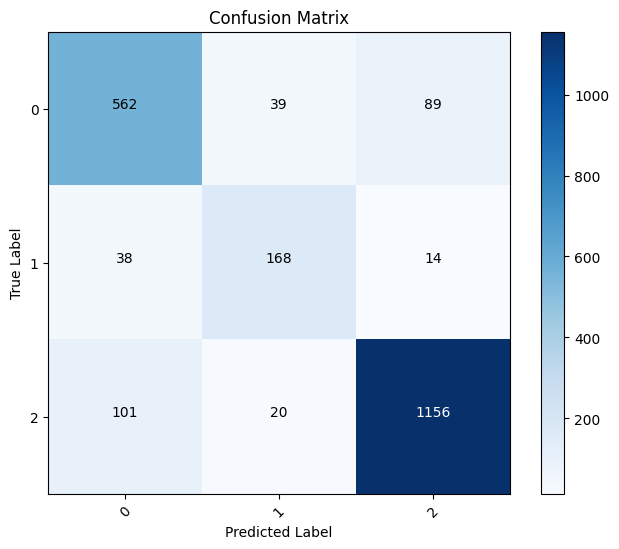


Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.81      0.81       690
           1       0.74      0.76      0.75       220
           2       0.92      0.91      0.91      1277

    accuracy                           0.86      2187
   macro avg       0.82      0.83      0.82      2187
weighted avg       0.86      0.86      0.86      2187



In [19]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Classification report
class_report = classification_report(y_test, y_pred)

# Visualizing the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
plt.xticks(tick_marks, np.unique(y_test), rotation=45)
plt.yticks(tick_marks, np.unique(y_test))
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Adding text annotations
thresh = conf_matrix.max() / 2
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, format(conf_matrix[i, j], 'd'), horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")
plt.show()

# ROC Curve and AUC for binary classification
if len(np.unique(y_test)) == 2:
    y_prob = model.predict_proba(X_test_bow)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Display classification report
print("\nClassification Report:\n", class_report)